# Line Tracing #

## Idea ##

Function: Main
1) Load 1 pixel Image
2) Give every pixel a id
3) Select a Starting Point
Function: Trace Line
1) Check all Pixels surrounding the Starting Point

In [1]:
import utils
import classes
import matplotlib.pyplot as plt
import networkx as nx
import igraph as g

In [2]:
imageArray = utils.load1BitBWImage("./../src/testImages/","0.png")
colorImage = utils.loadRGBImage("./../src/testImages/","0.png")

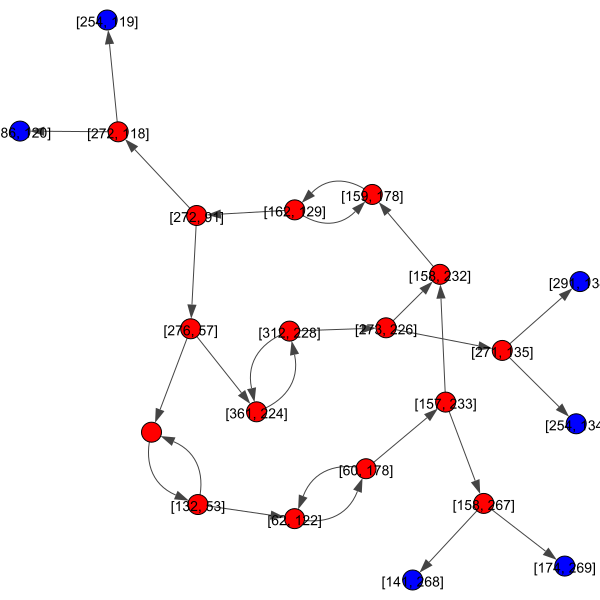

In [8]:
imageArray = utils.load1BitBWImage("./../src/testImages/","newThin.png")

class NodeType():
    pass
class EndNode(NodeType):
    pass
class IntersectionNode(NodeType):
    pass 
class CornerNode(NodeType):
    pass

def getAdjacentPixel(image,currentPixel,blackList):
    #AdjacentPixel Array       
    adjacentPixels = [[-1,-1],[0,-1],[1,-1], \
                        [-1,0],        [1,0], \
                        [-1,1], [0,1], [1,1]]
    validPixels = []
    for adj in adjacentPixels:
        adjacentPixel = [currentPixel[0]+adj[0],currentPixel[1]+adj[1]]
        if image[adjacentPixel[1]][adjacentPixel[0]] == 1:
            if not adjacentPixel in blackList:
                validPixels.append(adjacentPixel)
    return validPixels

# gets first black pixel in image
def findStaringPoint(image):
    for y in range(0,len(image)):
        for x in range(0,len(image)):
            if image[y][x] == 1:
                return [x,y]

## Runs along line until it finds the first Intersection or the first Endpoint
def findValidPoint(image,startPoint):
    def recursiveFindValidPoint(currentPixel,lastPixel):
        adjacentPixels = getAdjacentPixel(image,currentPixel,[])
        if len(adjacentPixels) > 2:
            return currentPixel
        if len(adjacentPixels) == 1:
            return currentPixel
        adjacentPixels = getAdjacentPixel(image,currentPixel,[lastPixel]) 
        return recursiveFindValidPoint(adjacentPixels[0],currentPixel)
    return recursiveFindValidPoint(startPoint,None)



def generateGraph(image,startPoint):
    visitedPixels = []
    graph = g.Graph(directed=True)
    graph.add_vertex(str(startPoint), color="red")
    
    def recursiveGenerateGraph(currentPixel,lastPixel,lastGraphNode):

        #End Recursion if loop ends
        if currentPixel in visitedPixels:
            if len(graph.vs.select(name=str(currentPixel))):
                graph.add_edge(str(lastGraphNode),str(currentPixel))
            return

        visitedPixels.append(currentPixel)
        adjacentPixels = getAdjacentPixel(image,currentPixel,[lastPixel])
        if len(adjacentPixels) == 0:
            #ENDPOINT
            if(str(currentPixel) != lastGraphNode):
                graph.add_vertex(str(currentPixel),label=str(currentPixel),color="blue", nodeType=EndNode())
                graph.add_edge(str(lastGraphNode),str(currentPixel))
        elif len(adjacentPixels) == 1:
            #LINE
            recursiveGenerateGraph(adjacentPixels[0],currentPixel,lastGraphNode)
        else:
            #INTERSECTION
            if(str(currentPixel) != lastGraphNode):
                graph.add_vertex(str(currentPixel),label=str(currentPixel),color="red",nodeType=IntersectionNode())
                graph.add_edge(str(lastGraphNode),str(currentPixel))
            for adjacentPixel in adjacentPixels:
                recursiveGenerateGraph(adjacentPixel,currentPixel,str(currentPixel))

    recursiveGenerateGraph(startPoint,None,str(startPoint))
    return graph,visitedPixels

graphCollection = []
while True:
    startingPoint = findStaringPoint(imageArray)
    startingPoint = findValidPoint(imageArray,startingPoint)
    G,visitedPixels = generateGraph(imageArray,startingPoint)
    graphCollection.append(G)
    #Remove all visited Pixels
    for visitedPixel in visitedPixels:
        imageArray[visitedPixel[1]][visitedPixel[0]] = 0

    #Check if image is only white
    sum = 0
    def addSum(pixel):global sum; sum += pixel
    utils.foreachPixel(imageArray,addSum)
    if sum < 10:
        break

union = g.union(graphCollection)

layout = union.layout("large_graph")
g.plot(union, layout=layout)


### Pattern detection

In [22]:
def getColorList(graph):
    colorList = []
    for vert in graph.vs:
        if vert["color"] == "red":
            colorList.append(0)
        elif vert["color"] == "blue":
            colorList.append(1)
        elif vert["color"] == "yellow":
            colorList.append(2)
    return colorList

def getPatternMatches(graph,pattern):
    mapings = graph.get_subisomorphisms_vf2(pattern,color1=getColorList(graph),color2=getColorList(pattern))
    result = []
    for i in range(0,len(mapings),2):
        result.append(list( map(lambda node:union.vs.find(node)["name"] ,mapings[i]) ))
    return result

[['[254, 134]', '[271, 135]', '[291, 134]'], ['[254, 119]', '[272, 118]', '[286, 120]'], ['[141, 268]', '[158, 267]', '[174, 269]']]


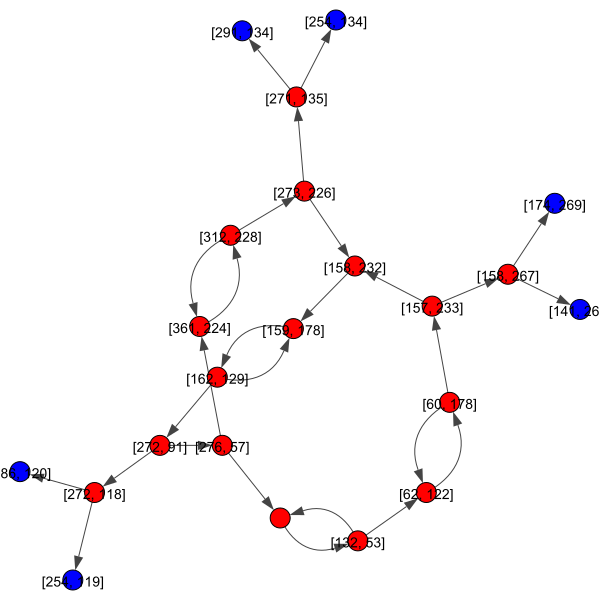

In [23]:
ground = g.Graph(directed=True)
ground.add_vertex(0,color="blue")
ground.add_vertex(1,color="red")
ground.add_vertex(2,color="blue")
ground.add_edge(1,0)
ground.add_edge(1,2)

print(getPatternMatches(union,ground))


layout = union.layout("kk")
g.plot(union, layout=layout)